# Error model validator

Build a set of data with a known statistical distribution and validate the error propagation by ensuring the integrated data follow the 𝜒² distribution.

This requires plenty of memory and is pretty compute intensive.

In [1]:
%matplotlib widget
import time
start_time = time.perf_counter()
import sys
print(sys.executable, sys.version)
import numpy
from scipy.stats import chi2 as chi2_dist
from matplotlib.pyplot import subplots
from pyFAI.method_registry import IntegrationMethod

/users/kieffer/.venv/py311/bin/python 3.11.0 | packaged by conda-forge | (main, Jan 14 2023, 12:27:40) [GCC 11.3.0]


In [2]:
from pyFAI.detectors import Detector
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator
from pyFAI.units import to_unit

class Validator:
    def __init__(self, nimg = 100, npt=700, shape = (1024, 1024), pix = 100e-6, I0=1e4):
        self.pix = pix
        self.shape = shape
        self.npt = npt
        self.nimg = nimg
        self.I0 = I0
        self.unit = to_unit("r_mm")
        self._ai = None
        self._img = None
        self._dataset = None
    
    @property
    def ai(self):
        if self._ai is None:
            detector = Detector(self.pix, self.pix)
            detector.shape=detector.max_shape=self.shape
            self._ai = AzimuthalIntegrator(dist=1.0, detector=detector)
        return self._ai
    
    def build_image(self):
        "Reconstruction of diffusion image"
        r_max = self.ai.detector.get_pixel_corners().max(axis=(0,1,2))
        r = numpy.linspace(0, 50*numpy.dot(r_max,r_max)**0.5, self.npt)
        I = self.I0/(1.0+r*r) #Lorentzian shape
                                                         
        img = self.ai.calcfrom1d(r, I, dim1_unit=self.unit, 
                            correctSolidAngle=False, 
                            polarization_factor=None)
        return img
    
    @property
    def img(self):
        if self._img is None:
            self._img = self.build_image()
        return self._img
    
    def build_dataset(self):
        return numpy.random.poisson(self.img, (self.nimg,) + self.shape)
    
    @property
    def dataset(self):
        if self._dataset is None:
            self._dataset = self.build_dataset()
        return self._dataset
    
    @staticmethod
    def chi2(res1, res2):
        """Calculate the 𝜒² value for a pair of 1d integrated data"""
        I = res1.intensity
        J = res2.intensity
        l = len(I)
        assert len(J) == l
        sigma_I = res1.sigma
        sigma_J = res2.sigma
        return ((I-J)**2/(sigma_I**2+sigma_J**2)).sum()/(l-1)
    
    
    def plot_distribution(self, kwargs, nbins=100, integrate=None, ax=None, label="Integrated curves" ):
        ai = self.ai
        dataset = self.dataset
        ai.reset()
        results = []
        c2 = []
        kwargs = kwargs.copy()
        if integrate is None:
            integrate = ai.integrate1d_ng
        t0 = time.perf_counter()
        if "npt" in kwargs:
            npt = kwargs["npt"]
        else:
            npt = kwargs["npt"] = self.npt
            
        if "unit" not in kwargs:
            kwargs["unit"] = self.unit
        for i in range(self.nimg):
            data = dataset[i, :, :]
            r = integrate(data, **kwargs)
            results.append(r)    
            for j in results[:i]:
                c2.append(self.chi2(r, j))
        print(f"Integration speed: {self.nimg/(time.perf_counter()-t0):6.3f} fps")
        c2 = numpy.array(c2)
        if ax is None:
            fig, ax = subplots()
        h,b,_ = ax.hist(c2, nbins, label="Measured distibution")
        y_sim = chi2_dist.pdf(b*(npt-1), npt)
        y_sim *= h.sum()/y_sim.sum()
        ax.plot(b, y_sim, label=r"Chi^2 distribution")
        ax.set_title(label)
        ax.legend()
        return ax

# kwarg = {"npt":npt, 
#          "correctSolidAngle":False, 
#          "polarization_factor":None,
#          "safe":False}
validator = Validator(nimg = 1000)
%time validator.dataset.min()

CPU times: user 1min, sys: 11.1 s, total: 1min 12s
Wall time: 1min 12s


110

IntegrationMethod(1d int, no split, CSR, python)
Integration speed: 30.883 fps
Integration speed: 25.685 fps


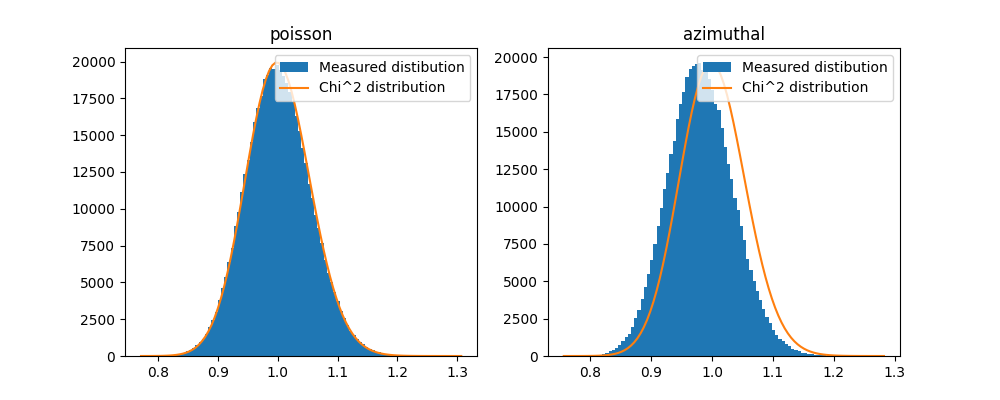

In [3]:
kwargs = {"error_model": "poisson",
          "correctSolidAngle":False, 
          "polarization_factor":None,
          "safe":False}
kwargs["method"] = IntegrationMethod.select_method(dim=1, 
                                                   split="no", 
                                                   algo="csr", 
                                                   impl="python")[0]
print(kwargs["method"])
fig,ax = subplots(1, 2, figsize=(10,4))
validator.plot_distribution(kwargs, label=kwargs["error_model"], ax=ax[0])

kwargs["error_model"]= "azimuthal"
validator.plot_distribution(kwargs, label=kwargs["error_model"], ax=ax[1])
pass

IntegrationMethod(1d int, bbox split, CSR, python)
Integration speed: 29.195 fps
Integration speed: 19.656 fps


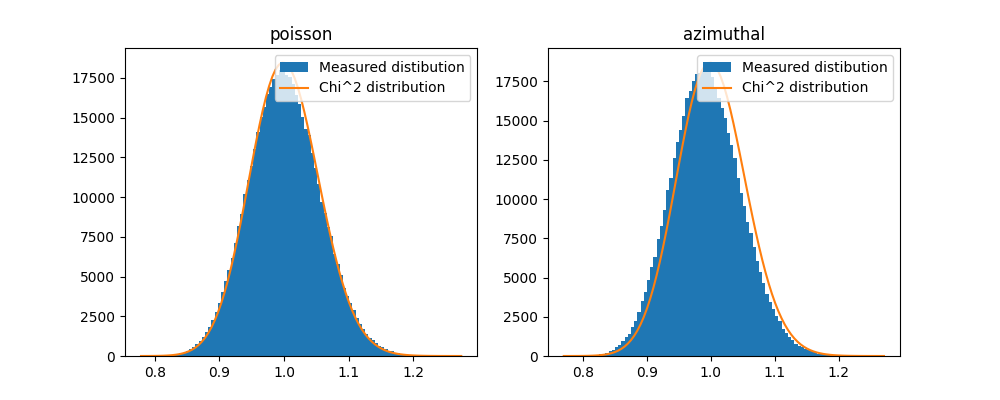

In [4]:
kwargs = {"error_model": "poisson",
          "correctSolidAngle":False, 
          "polarization_factor":None,
          "safe":False}
kwargs["method"] = IntegrationMethod.select_method(dim=1, 
                                                   split="bbox", 
                                                   algo="csr", 
                                                   impl="python")[0]
print(kwargs["method"])
fig,ax = subplots(1, 2, figsize=(10,4))
validator.plot_distribution(kwargs, label=kwargs["error_model"], ax=ax[0])

kwargs["error_model"]= "azimuthal"
validator.plot_distribution(kwargs, label=kwargs["error_model"], ax=ax[1])
pass

IntegrationMethod(1d int, no split, CSR, cython)
Integration speed: 43.228 fps
Integration speed: 42.036 fps


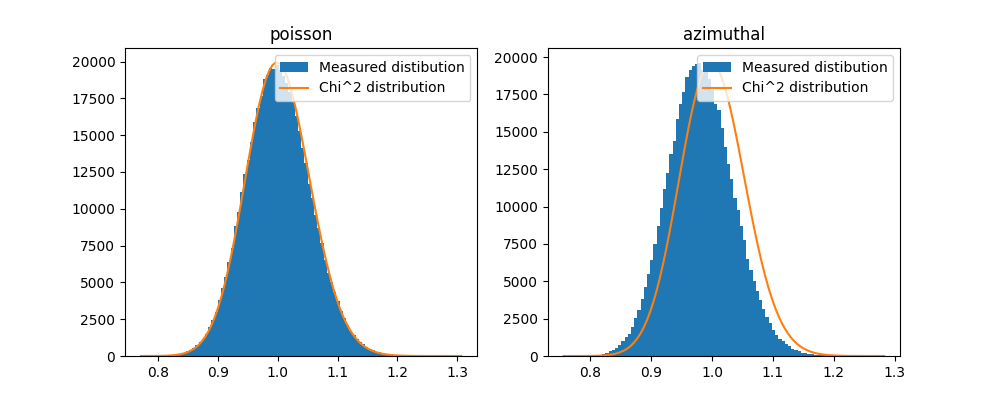

In [5]:
kwargs = {"error_model": "poisson",
          "correctSolidAngle":False, 
          "polarization_factor":None,
          "safe":False}
kwargs["method"] = IntegrationMethod.select_method(dim=1, 
                                                   split="no", 
                                                   algo="csr", 
                                                   impl="cython")[0]
print(kwargs["method"])
fig,ax = subplots(1, 2, figsize=(10,4))
validator.plot_distribution(kwargs, label=kwargs["error_model"], ax=ax[0])

kwargs["error_model"]= "azimuthal"
validator.plot_distribution(kwargs, label=kwargs["error_model"], ax=ax[1])
pass

IntegrationMethod(1d int, bbox split, CSR, cython)
Integration speed: 41.569 fps
Integration speed: 40.779 fps


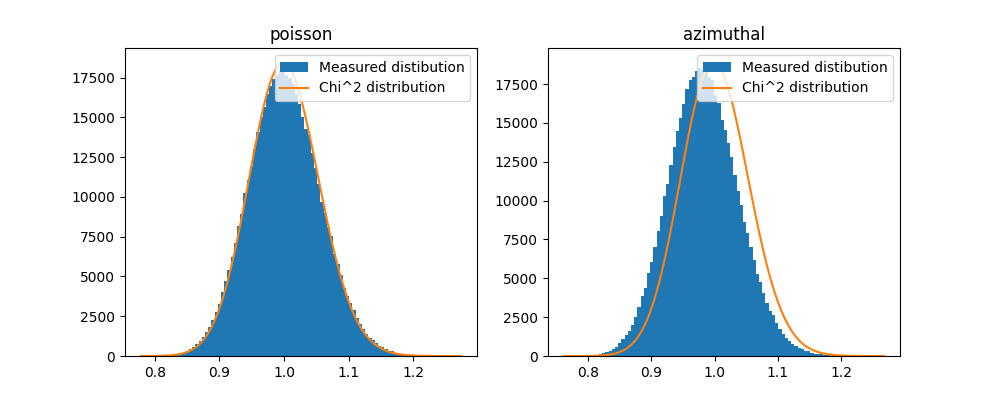

In [6]:
kwargs = {"error_model": "poisson",
          "correctSolidAngle":False, 
          "polarization_factor":None,
          "safe":False}
kwargs["method"] = IntegrationMethod.select_method(dim=1, 
                                                   split="bbox", 
                                                   algo="csr", 
                                                   impl="cython")[0]
print(kwargs["method"])
fig,ax = subplots(1, 2, figsize=(10,4))
validator.plot_distribution(kwargs, label=kwargs["error_model"], ax=ax[0])

kwargs["error_model"]= "azimuthal"
validator.plot_distribution(kwargs, label=kwargs["error_model"], ax=ax[1])
pass

IntegrationMethod(1d int, no split, CSR, cython)
Integration speed: 43.309 fps
Integration speed: 42.080 fps


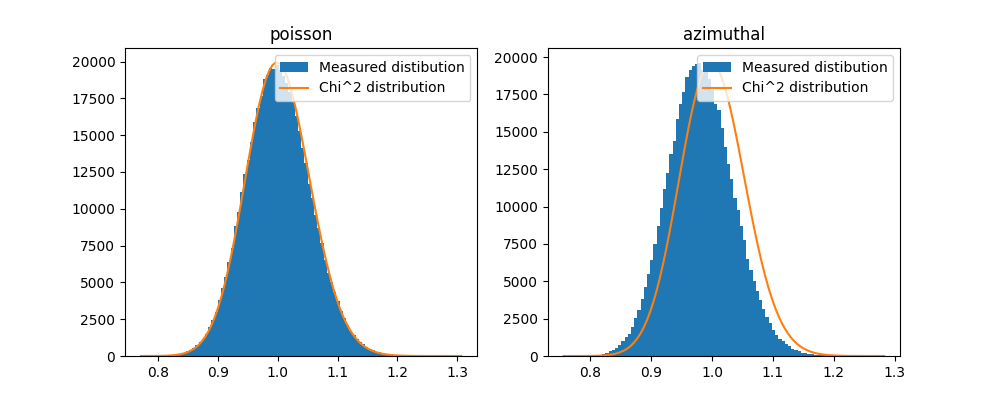

In [7]:
kwargs = {"error_model": "poisson",
          "correctSolidAngle":False, 
          "polarization_factor":None,
          "safe":False}
kwargs["method"] = IntegrationMethod.select_method(dim=1, 
                                                   split="no", 
                                                   algo="csr", 
                                                   impl="opencl",
                                                   target=(1,1))[0]
print(kwargs["method"])
fig,ax = subplots(1, 2, figsize=(10,4))

validator.plot_distribution(kwargs, label=kwargs["error_model"], ax=ax[0])
kwargs["error_model"]= "azimuthal"
validator.plot_distribution(kwargs, label=kwargs["error_model"], ax=ax[1])
pass

IntegrationMethod(1d int, bbox split, CSR, cython)
Integration speed: 41.866 fps
Integration speed: 40.515 fps


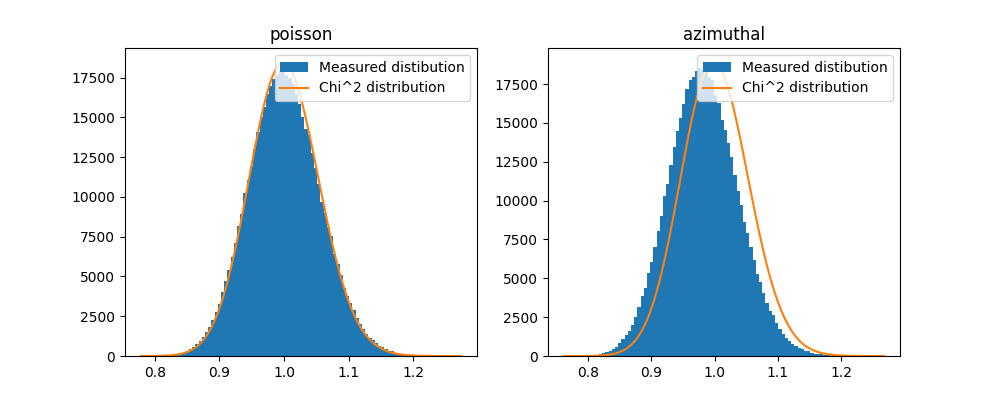

In [8]:

kwargs = {"error_model": "poisson",
          "correctSolidAngle":False, 
          "polarization_factor":None,
          "safe":False}
kwargs["method"] = IntegrationMethod.select_method(dim=1, 
                                                   split="bbox", 
                                                   algo="csr", 
                                                   impl="opencl",
                                                   target=(1,1))[0]
print(kwargs["method"])
fig,ax = subplots(1, 2, figsize=(10,4))
validator.plot_distribution(kwargs, label=kwargs["error_model"], ax=ax[0])

kwargs["error_model"]= "azimuthal"
validator.plot_distribution(kwargs, label=kwargs["error_model"], ax=ax[1])
pass